# **EDA of 400 samples from amazon_del**  
Here I am doing an EDA on this sample in order to prepare them for a prediction model of Delivery time.  

## **Packages**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
from geopy.geocoders import Nominatim
import haversine as hs
from haversine import Unit
from modules_amazon import Location
import pickle

In [3]:
with open("amazon_sample400.pkl", "rb") as f:
    amazon_sample400 = pickle.load(f)

# **Checking** 

In [4]:
print(amazon_sample400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Order_ID                398 non-null    object         
 1   Agent_Age               398 non-null    int64          
 2   Agent_Rating            398 non-null    float64        
 3   Store_Latitude          398 non-null    float64        
 4   Store_Longitude         398 non-null    float64        
 5   Drop_Latitude           398 non-null    float64        
 6   Drop_Longitude          398 non-null    float64        
 7   Order_Date              398 non-null    datetime64[ns] 
 8   Order_Time              398 non-null    object         
 9   Pickup_Time             398 non-null    datetime64[ns] 
 10  Weather                 398 non-null    object         
 11  Traffic                 398 non-null    category       
 12  Vehicle                 398 non-null

In [5]:
amazon_sample400.drop(["Store_Latitude","Store_Longitude"], axis=1, inplace=True)

## **Cities**  
I have previously define the cities using the modules_amazon. However, in the EDA of the amazon_delivery I found 3180 rows with null coordinates of Store (represents around 7% of the all dataset).  
Here, I will check the cities that loc.city() had found. Especially where the corrdinates of the Store were null.

In [6]:
print(amazon_sample400["City"].isna().sum())
no_city = amazon_sample400[amazon_sample400["City"].isna()]
no_city

1


,Order_ID,Agent_Age,Agent_Rating,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance_Store_Drop_km,abs_Store_Latitude,abs_Store_Longitude,duration,duration_min,City
14998,nqmv986411624,37,4.6,18.556216,73.882527,2022-03-07,13:50:00,2024-12-05 14:00:00,Sunny,High,motorcycle,Metropolitan,130,Snacks,6.129158,18.516216,73.842527,0 days 00:10:00,10.0,None


In [7]:
loc = Location(18.5,73.8)
city = loc.city()

In [8]:
print(city)
print(loc.country())

Pune City
India


In [9]:
Pune_City = amazon_sample400[amazon_sample400["City"] == city]
print(Pune_City.info())
print(Pune_City[["abs_Store_Latitude","abs_Store_Longitude"]].describe())

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 3400 to 18798
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Order_ID                34 non-null     object         
 1   Agent_Age               34 non-null     int64          
 2   Agent_Rating            34 non-null     float64        
 3   Drop_Latitude           34 non-null     float64        
 4   Drop_Longitude          34 non-null     float64        
 5   Order_Date              34 non-null     datetime64[ns] 
 6   Order_Time              34 non-null     object         
 7   Pickup_Time             34 non-null     datetime64[ns] 
 8   Weather                 34 non-null     object         
 9   Traffic                 34 non-null     category       
 10  Vehicle                 34 non-null     category       
 11  Area                    34 non-null     category       
 12  Delivery_Time           34 non-null  

In [10]:
amazon_sample400["City"] = amazon_sample400["City"].fillna("Pune City")

I apparently don't have any null Store coordinates values in my sample.  
The only null City value was one that was found to be in Pune City. During the calculation (which requires internet access) this row might have been skipped.  

In [11]:
print(amazon_sample400["City"].unique())

['' 'Kolkata' 'Surat' 'Bengaluru' 'Prayagraj' 'Mysuru' 'Mumbai Suburban'
 'Chhatrapati Sambhaji Nagar' 'Hyderabad' 'Kanpur' 'Pune City' 'Chennai'
 'Ranchi' 'Ludhiana' 'Jaipur' 'Ernakulam' 'Bhopal' 'Indore' 'Mumbai City'
 'Agra' 'Vadodara' 'Coimbatore' 'Dehradun' 'Thane' 'Panaji']


In [12]:
empty_cities = amazon_sample400[amazon_sample400["City"] == ""]
print(empty_cities[["abs_Store_Latitude","abs_Store_Longitude"]].describe())

       abs_Store_Latitude  abs_Store_Longitude
count          103.000000           103.000000
mean            11.804214            55.019124
std              8.357637            33.846224
min              0.000000             0.000000
25%              0.000000             0.000000
50%             12.933284            73.165012
75%             21.149669            76.997008
max             30.885814            80.249982


In [13]:
print(empty_cities["Area"].value_counts())

Area
Metropolitan    85
Urban           16
Other            2
Semi-Urban       0
Name: count, dtype: int64


I won't remove them. I have a total of 103 null Store coordinates. However, I have the Area information which can be useful when comparing the traffic.

# **Validation of the features for the predictive model**

## **Are the cities that relevant?**  
The problem is that the number of cities is very large (24 + unknowns). This can be problematique for the model.  
If there is no relationship between the cities and delivery time we can not only remove this feature but also the coordinates (Store and Drop since I have calculated the distance already).  
I will perhaps need to find the size of the population of each city and/or their geographical situations.

In [14]:
amazon_sample400["City"] = amazon_sample400["City"].replace("","Unknown")
print(amazon_sample400["City"].value_counts(normalize=True))

City
Unknown                       0.258794
Mysuru                        0.090452
Pune City                     0.087940
Jaipur                        0.057789
Mumbai Suburban               0.055276
Hyderabad                     0.055276
Ranchi                        0.055276
Chennai                       0.050251
Bengaluru                     0.042714
Indore                        0.042714
Surat                         0.032663
Coimbatore                    0.020101
Kanpur                        0.017588
Kolkata                       0.017588
Chhatrapati Sambhaji Nagar    0.015075
Prayagraj                     0.015075
Bhopal                        0.015075
Ludhiana                      0.015075
Mumbai City                   0.012563
Agra                          0.012563
Ernakulam                     0.010050
Vadodara                      0.007538
Dehradun                      0.007538
Thane                         0.002513
Panaji                        0.002513
Name: proportion, dt

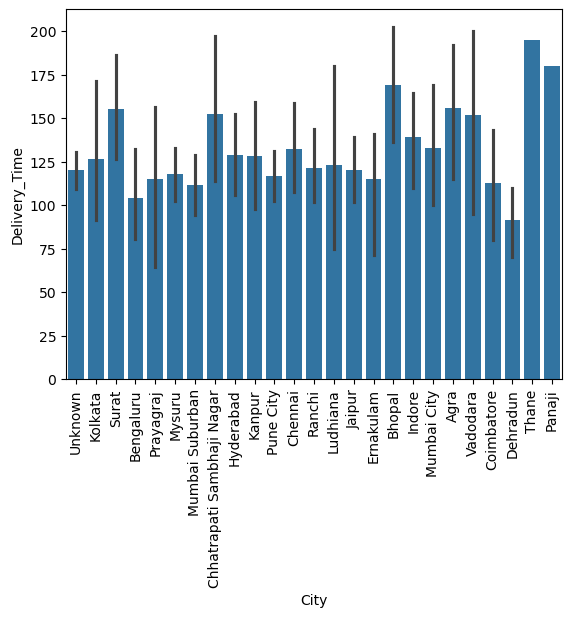

In [70]:
sns.barplot(x="City", y="Delivery_Time", data=amazon_sample400)
plt.xticks(rotation=90)
plt.show()

In [15]:
print(amazon_sample400["Area"].value_counts())

Area
Metropolitan    313
Urban            77
Other             8
Semi-Urban        0
Name: count, dtype: int64


I have no Semi-Urban in this sample.  
I have to remember to check this category in amazon_del

In [16]:
amazon_sample400["Area"] = amazon_sample400["Area"].cat.remove_categories("Semi-Urban")

In [17]:
area_cities = amazon_sample400.groupby("Area")["City"].unique()
area_cities

C:\Users\Angelique\AppData\Local\Temp\ipykernel_26400\1398955054.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_cities = amazon_sample400.groupby("Area")["City"].unique()


Area
Other           [Unknown, Hyderabad, Mumbai Suburban, Bengalur...
Urban           [Unknown, Mysuru, Mumbai Suburban, Hyderabad, ...
Metropolitan    [Unknown, Kolkata, Surat, Bengaluru, Prayagraj...
Name: City, dtype: object

In [18]:
print(area_cities["Metropolitan"])

['Unknown' 'Kolkata' 'Surat' 'Bengaluru' 'Prayagraj' 'Mumbai Suburban'
 'Chhatrapati Sambhaji Nagar' 'Mysuru' 'Kanpur' 'Pune City' 'Hyderabad'
 'Chennai' 'Ranchi' 'Ludhiana' 'Jaipur' 'Ernakulam' 'Bhopal' 'Indore'
 'Agra' 'Vadodara' 'Coimbatore' 'Mumbai City' 'Thane' 'Panaji' 'Dehradun']


In [19]:
print(area_cities["Urban"])

['Unknown' 'Mysuru' 'Mumbai Suburban' 'Hyderabad' 'Kolkata' 'Ranchi'
 'Pune City' 'Jaipur' 'Chennai' 'Bengaluru' 'Mumbai City' 'Kanpur'
 'Ludhiana' 'Surat' 'Bhopal' 'Dehradun' 'Agra' 'Indore' 'Coimbatore']


In [20]:
print(area_cities["Other"])

['Unknown' 'Hyderabad' 'Mumbai Suburban' 'Bengaluru' 'Coimbatore'
 'Ernakulam' 'Ranchi']


Same cities appear in both Urban,Metropolitan and Other areas. 

In [21]:
print(amazon_sample400.groupby("Traffic")["Area"].value_counts())

Traffic  Area        
Low      Metropolitan    106
         Urban            31
         Other             3
Medium   Metropolitan     75
         Urban            18
         Other             3
High     Metropolitan     39
         Urban            12
         Other             2
Jam      Metropolitan     93
         Urban            16
         Other             0
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_26400\3871292136.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(amazon_sample400.groupby("Traffic")["Area"].value_counts())


I think we can remove the following features:  
- City;  
- abs_Store_Latitude;  
- abs_Store_Longitude;  
- Drop_Latitude;  
- Drop_Longitude;  


## **Removing the above features**

In [22]:
samples400 = amazon_sample400.drop(["City","abs_Store_Latitude","abs_Store_Longitude","Drop_Latitude","Drop_Longitude"], axis=1)
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Order_ID                398 non-null    object         
 1   Agent_Age               398 non-null    int64          
 2   Agent_Rating            398 non-null    float64        
 3   Order_Date              398 non-null    datetime64[ns] 
 4   Order_Time              398 non-null    object         
 5   Pickup_Time             398 non-null    datetime64[ns] 
 6   Weather                 398 non-null    object         
 7   Traffic                 398 non-null    category       
 8   Vehicle                 398 non-null    category       
 9   Area                    398 non-null    category       
 10  Delivery_Time           398 non-null    int64          
 11  Category                398 non-null    object         
 12  Distance_Store_Drop_km  398 non-null

## **Validation of the duration**  
Is there a relationship between the duration (time between order and pickup) and the delivery time?  


<Axes: xlabel='duration_min', ylabel='Delivery_Time'>

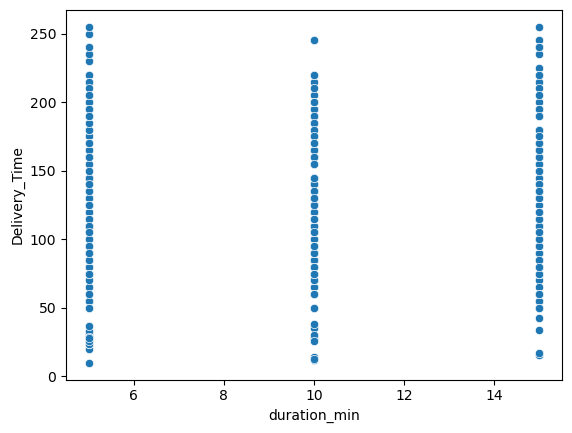

In [23]:
sns.scatterplot(x="duration_min", y="Delivery_Time", data=samples400)

In [24]:
print(samples400["duration_min"].value_counts())

duration_min
5.0     137
10.0    135
15.0    126
Name: count, dtype: int64


<Axes: xlabel='duration_min', ylabel='Delivery_Time'>

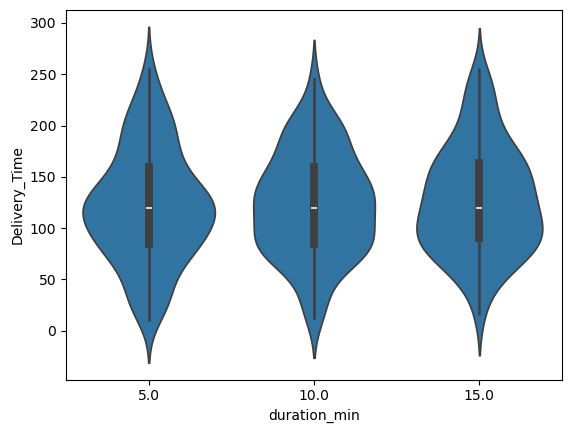

In [25]:
samples400["duration_min"] = samples400["duration_min"].astype("category")
sns.violinplot(x="duration_min", y="Delivery_Time", data=samples400)

There are no obvious differences between the 3 durations.  
I can remove the duration.

In [26]:
samples400.drop(["duration","duration_min"], axis=1, inplace=True)

## **Does the day matter?**  
I am not sure wheter in India sunday is the day rest.  
Maybe we should se a difference if one of the day of the week is a rest day.

In [27]:
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                398 non-null    object        
 1   Agent_Age               398 non-null    int64         
 2   Agent_Rating            398 non-null    float64       
 3   Order_Date              398 non-null    datetime64[ns]
 4   Order_Time              398 non-null    object        
 5   Pickup_Time             398 non-null    datetime64[ns]
 6   Weather                 398 non-null    object        
 7   Traffic                 398 non-null    category      
 8   Vehicle                 398 non-null    category      
 9   Area                    398 non-null    category      
 10  Delivery_Time           398 non-null    int64         
 11  Category                398 non-null    object        
 12  Distance_Store_Drop_km  398 non-null    float64   

In [28]:
print(samples400["Order_Date"].min())
print(samples400["Order_Date"].max())

2022-02-11 00:00:00
2022-04-06 00:00:00


In [29]:
samples400["Order_Day"] = samples400["Order_Date"].dt.weekday


<Axes: xlabel='Order_Day', ylabel='Delivery_Time'>

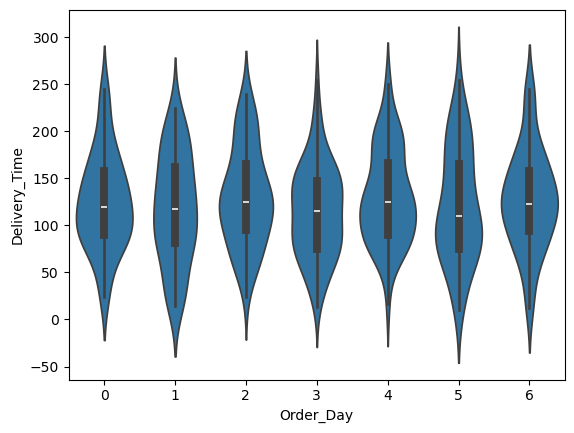

In [30]:
sns.violinplot(x="Order_Day", y="Delivery_Time", data=samples400)

The shape distribution of the delivery time is slightly different between the weekdays.  
So I think it's worth to keep this feature but perhaps we can remove the Order_date as it is redundant.  
I am also removing Order_Time as we saw above that there is no relationship between the time spent between order and pickup and Delivery_Time.

In [31]:
samples400.drop(["Order_Date","Order_Time"], axis=1, inplace=True)

In [32]:
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                398 non-null    object        
 1   Agent_Age               398 non-null    int64         
 2   Agent_Rating            398 non-null    float64       
 3   Pickup_Time             398 non-null    datetime64[ns]
 4   Weather                 398 non-null    object        
 5   Traffic                 398 non-null    category      
 6   Vehicle                 398 non-null    category      
 7   Area                    398 non-null    category      
 8   Delivery_Time           398 non-null    int64         
 9   Category                398 non-null    object        
 10  Distance_Store_Drop_km  398 non-null    float64       
 11  Order_Day               398 non-null    int32         
dtypes: category(3), datetime64[ns](1), float64(2), int

## **Agent Age**

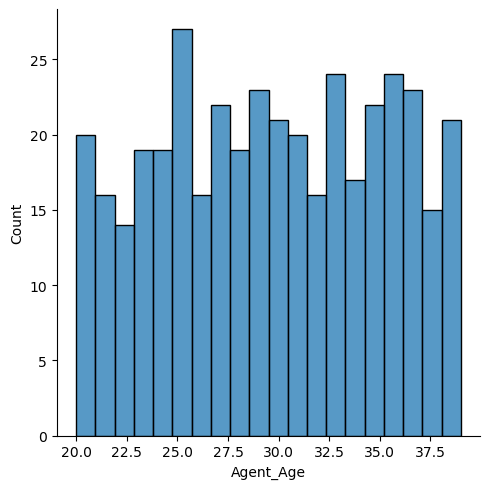

In [33]:
sns.displot(samples400["Agent_Age"], bins=20)

The distribution of the agent age is closer to a uniform distribution. 

<Axes: xlabel='Agent_Age', ylabel='Delivery_Time'>

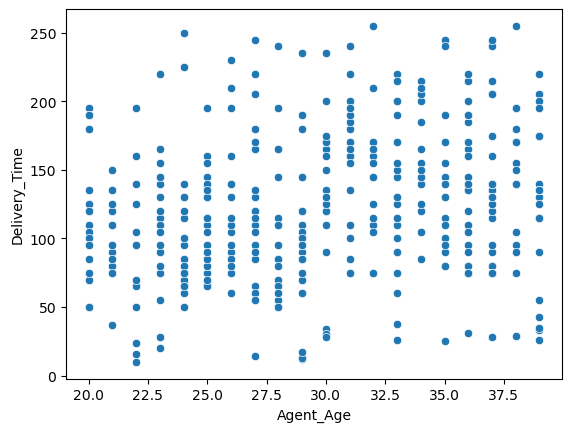

In [34]:
sns.scatterplot(x="Agent_Age", y="Delivery_Time", data=samples400)

We do not have a linear relationship, but we can see 2 categories:  
- More or equal 30 years old;  
- < 30 years old.  
I will make a column with these 2 categories and see if we can see differences.

### **The under 30 vs the older agents**

In [35]:
samples400["Young_vs_Older_Agents"] = np.where(samples400["Agent_Age"] < 30, "Under 30","30+")
samples400["Young_vs_Older_Agents"] = samples400["Young_vs_Older_Agents"].astype("category")
order_age_range = ["Under 30", "30+"]
samples400["Young_vs_Older_Agents"] = samples400["Young_vs_Older_Agents"].cat.\
    reorder_categories(new_categories=order_age_range, ordered=True)

<Axes: xlabel='Young_vs_Older_Agents', ylabel='Delivery_Time'>

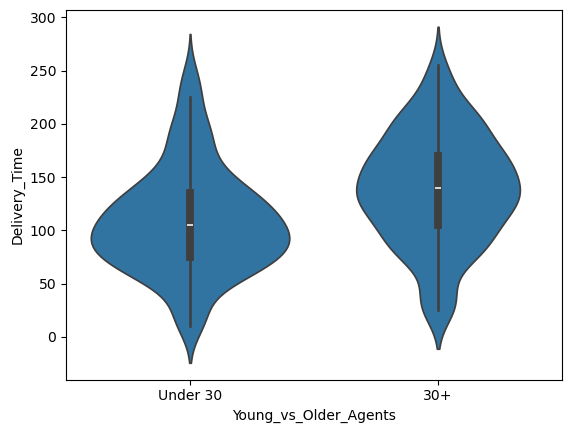

In [36]:
sns.violinplot(x="Young_vs_Older_Agents", y="Delivery_Time", data=samples400)

We can see a difference between young and older agents. Is that difference significative?  
If it is then I will keep this fetaure.  
I will do a Mann-Whitney U test.  

In [37]:
from scipy.stats import mannwhitneyu

age_stat, age_pval = mannwhitneyu(samples400[samples400["Young_vs_Older_Agents"] == "Under 30"]["Delivery_Time"],\
                                  samples400[samples400["Young_vs_Older_Agents"] == "30+"]["Delivery_Time"])
print(age_pval)

6.278748055650641e-10


The difference (of the median Delivery_Time values) is largely significantly different.  
I will keep this feature but I will remove the Agent_Age feature as among each age caetgory there are no obvious patterns (see scatterplot).  

In [38]:
samples400 = samples400.drop("Agent_Age", axis=1)

In [39]:
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                398 non-null    object        
 1   Agent_Rating            398 non-null    float64       
 2   Pickup_Time             398 non-null    datetime64[ns]
 3   Weather                 398 non-null    object        
 4   Traffic                 398 non-null    category      
 5   Vehicle                 398 non-null    category      
 6   Area                    398 non-null    category      
 7   Delivery_Time           398 non-null    int64         
 8   Category                398 non-null    object        
 9   Distance_Store_Drop_km  398 non-null    float64       
 10  Order_Day               398 non-null    int32         
 11  Young_vs_Older_Agents   398 non-null    category      
dtypes: category(4), datetime64[ns](1), float64(2), int

## **Agent_Rating**

<Axes: xlabel='Agent_Rating', ylabel='Delivery_Time'>

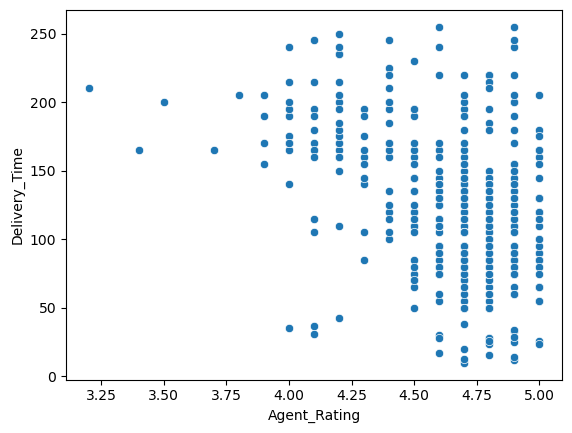

In [40]:
sns.scatterplot(x="Agent_Rating", y="Delivery_Time", data=samples400)

I can see a negative relationship between the rating and the delivery time. Shorter is the delivery, better is the rating.

In [41]:
print(samples400["Agent_Rating"].describe())
rating_inf4 = samples400[samples400["Agent_Rating"] < 4]
print(len(rating_inf4)/len(samples400))

count    398.000000
mean       4.633920
std        0.293987
min        3.200000
25%        4.500000
50%        4.700000
75%        4.800000
max        5.000000
Name: Agent_Rating, dtype: float64
0.022613065326633167


I'm keeping the feature the way it is.

## **Pickup_Time**  
I will make a column to group the data by the hours.

<Axes: xlabel='Pickup_Time_hour', ylabel='Delivery_Time'>

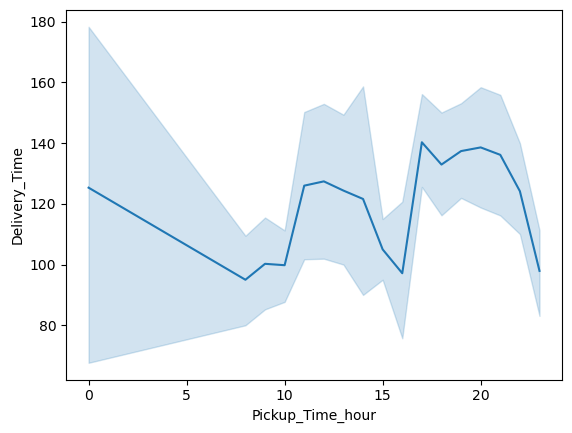

In [42]:
samples400["Pickup_Time_hour"] = samples400["Pickup_Time"].dt.hour
sns.lineplot(x="Pickup_Time_hour", y="Delivery_Time", data=samples400)

In [43]:
print(samples400["Pickup_Time_hour"].value_counts())

Pickup_Time_hour
22    47
19    46
18    39
23    35
20    35
17    34
21    33
10    24
9     20
11    20
12    17
14    13
8     10
13     8
16     7
0      6
15     4
Name: count, dtype: int64


There are no data between 0 and 8, which is expected. However we do have 6 rows for a pickup between midnight and 1am. 

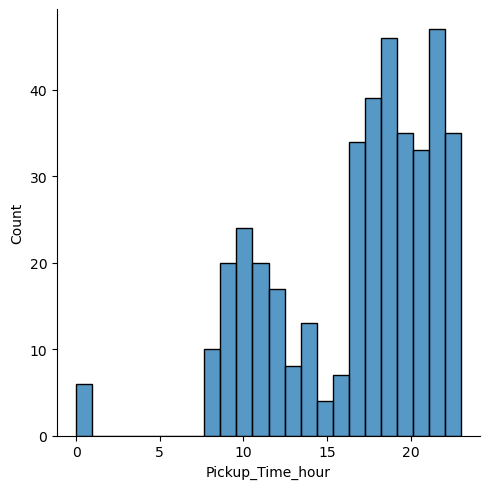

In [44]:
sns.displot(samples400["Pickup_Time_hour"], bins=24)

<Axes: xlabel='Pickup_Time_hour', ylabel='Delivery_Time'>

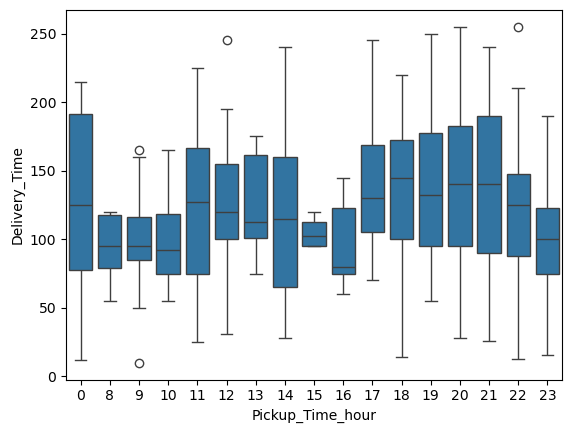

In [45]:
sns.boxplot(x="Pickup_Time_hour", y="Delivery_Time", data=samples400)

The variability is very wide making difficult to interpret the Delivery time.  
I will group them by periods:  
- night: 23-0;  
- morning: 08-10;  
- midday: 11-13;
- afternoon: 14-16;  
- early evening: 17-19;  
- evening: 20-22.  
 

In [46]:
period_day = {0:"Night", 8:"Morning", 9:"Morning", 10:"Morning", 11:"Midday", 12:"Midday", 13:"Midday",\
              14:"Afternoon", 15:"Afternoon", 16:"Afternoon", 17:"Early evening", 18:"Early evening", 19:"Early evening",\
                20:"Evening", 21:"Evening", 22:"Evening", 23:"Night"}
samples400["Period_Day"] = samples400["Pickup_Time_hour"].replace(period_day)
print(samples400["Period_Day"].value_counts())

Period_Day
Early evening    119
Evening          115
Morning           54
Midday            45
Night             41
Afternoon         24
Name: count, dtype: int64


<Axes: xlabel='Period_Day', ylabel='Delivery_Time'>

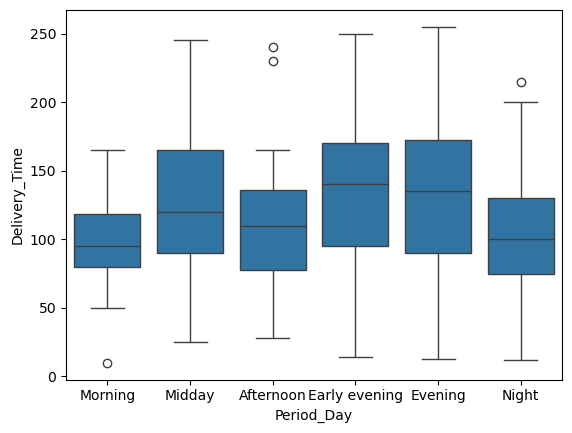

In [47]:
ordered_period_day = ["Morning", "Midday", "Afternoon", "Early evening", "Evening", "Night"]
samples400["Period_Day"] = samples400["Period_Day"].astype("category")
samples400["Period_Day"] = samples400["Period_Day"].cat.reorder_categories(new_categories=ordered_period_day, ordered=True)
sns.boxplot(x="Period_Day", y="Delivery_Time", data=samples400)

The variability is still large even among the larger groups. 

In [48]:
print(samples400.groupby("Period_Day")["Traffic"].value_counts(normalize=True))

Period_Day     Traffic
Morning        Low        1.000000
               Medium     0.000000
               High       0.000000
               Jam        0.000000
Midday         High       0.844444
               Low        0.155556
               Medium     0.000000
               Jam        0.000000
Afternoon      High       0.625000
               Medium     0.375000
               Low        0.000000
               Jam        0.000000
Early evening  Medium     0.731092
               Jam        0.268908
               Low        0.000000
               High       0.000000
Evening        Jam        0.669565
               Low        0.330435
               Medium     0.000000
               High       0.000000
Night          Low        1.000000
               Medium     0.000000
               High       0.000000
               Jam        0.000000
Name: proportion, dtype: float64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_26400\2111583103.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(samples400.groupby("Period_Day")["Traffic"].value_counts(normalize=True))


For both morning and night where the median Delivery_Time is lower (<= 100min) we only have low traffic which is comforting.  
However, the difference doesn't seem that big.

In [49]:
print(samples400.groupby("Period_Day")["Delivery_Time"].describe())

               count        mean        std   min   25%    50%     75%    max
Period_Day                                                                   
Morning         54.0   99.074074  31.218555  10.0  80.0   95.0  118.75  165.0
Midday          45.0  126.244444  51.448631  25.0  90.0  120.0  165.00  245.0
Afternoon       24.0  111.708333  52.412643  28.0  77.5  110.0  136.25  240.0
Early evening  119.0  136.764706  51.902403  14.0  95.0  140.0  170.00  250.0
Evening        115.0  132.000000  57.687908  13.0  90.0  135.0  172.50  255.0
Night           41.0  101.926829  49.332236  12.0  75.0  100.0  130.00  215.0


C:\Users\Angelique\AppData\Local\Temp\ipykernel_26400\4103352088.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(samples400.groupby("Period_Day")["Delivery_Time"].describe())


The larger variability from the period other than Morning and night might come from the multiple categories.  
I will keep this feature but remove the Pickup_Time and Pickup_Time_hour.

In [50]:
samples400 = samples400.drop(["Pickup_Time","Pickup_Time_hour"], axis=1)

In [51]:
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Order_ID                398 non-null    object  
 1   Agent_Rating            398 non-null    float64 
 2   Weather                 398 non-null    object  
 3   Traffic                 398 non-null    category
 4   Vehicle                 398 non-null    category
 5   Area                    398 non-null    category
 6   Delivery_Time           398 non-null    int64   
 7   Category                398 non-null    object  
 8   Distance_Store_Drop_km  398 non-null    float64 
 9   Order_Day               398 non-null    int32   
 10  Young_vs_Older_Agents   398 non-null    category
 11  Period_Day              398 non-null    category
dtypes: category(5), float64(2), int32(1), int64(1), object(3)
memory usage: 26.0+ KB
None


## **Weather**


In [52]:
print(samples400["Weather"].unique())

['Sandstorms' 'Fog' 'Sunny' 'Windy' 'Cloudy' 'Stormy']


In [53]:
print(samples400.groupby("Traffic")["Weather"].value_counts())

Traffic  Weather   
Low      Cloudy        31
         Sandstorms    25
         Sunny         22
         Windy         22
         Fog           21
         Stormy        19
Medium   Fog           26
         Sandstorms    17
         Windy         16
         Sunny         14
         Cloudy        13
         Stormy        10
High     Sunny         16
         Fog            8
         Sandstorms     8
         Cloudy         7
         Stormy         7
         Windy          7
Jam      Sunny         24
         Sandstorms    22
         Windy         17
         Cloudy        16
         Fog           15
         Stormy        15
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_26400\3418787026.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(samples400.groupby("Traffic")["Weather"].value_counts())


<Axes: xlabel='Weather', ylabel='Delivery_Time'>

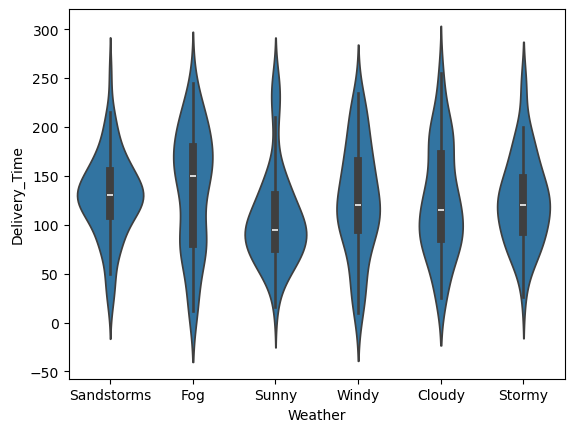

In [54]:
sns.violinplot(x="Weather", y="Delivery_Time", data=samples400)

In [55]:
print(samples400.groupby("Weather")["Delivery_Time"].describe())

            count        mean        std   min     25%    50%    75%    max
Weather                                                                    
Cloudy       67.0  123.701493  56.000816  25.0   85.00  115.0  172.5  255.0
Fog          70.0  136.271429  61.109529  12.0   80.00  150.0  180.0  245.0
Sandstorms   72.0  128.875000  42.970654  20.0  108.75  130.0  155.0  255.0
Stormy       51.0  125.313725  46.134798  26.0   92.50  120.0  147.5  245.0
Sunny        76.0  106.842105  49.161517  16.0   75.00   95.0  130.0  250.0
Windy        62.0  124.661290  56.080722  10.0   95.00  120.0  165.0  235.0


I am keeping the categories. Although the medians are not drastically different from each other, the distribution patterns are. Hence, they could potentially help in the model performance.  

I will order them based on the Delivery_Time (and variance?)

In [56]:
samples400["Weather"] = samples400["Weather"].astype("category")
order_Weather = ["Sunny","Cloudy","Fog","Stormy","Windy","Sandstorms"]
numerical_Weather = {"Sunny":1,"Cloudy":2,"Fog":3,"Stormy":4,"Windy":5,"Sandstorms":6}
samples400["Weather_Code"] = samples400["Weather"].replace(numerical_Weather)

C:\Users\Angelique\AppData\Local\Temp\ipykernel_26400\251294935.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  samples400["Weather_Code"] = samples400["Weather"].replace(numerical_Weather)
C:\Users\Angelique\AppData\Local\Temp\ipykernel_26400\251294935.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  samples400["Weather_Code"] = samples400["Weather"].replace(numerical_Weather)


In [57]:
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Order_ID                398 non-null    object  
 1   Agent_Rating            398 non-null    float64 
 2   Weather                 398 non-null    category
 3   Traffic                 398 non-null    category
 4   Vehicle                 398 non-null    category
 5   Area                    398 non-null    category
 6   Delivery_Time           398 non-null    int64   
 7   Category                398 non-null    object  
 8   Distance_Store_Drop_km  398 non-null    float64 
 9   Order_Day               398 non-null    int32   
 10  Young_vs_Older_Agents   398 non-null    category
 11  Period_Day              398 non-null    category
 12  Weather_Code            398 non-null    category
dtypes: category(7), float64(2), int32(1), int64(1), object(2)
memory usage: 24.0+ KB

## **Category**  
There are a lot of them. 

In [58]:
print(samples400["Category"].value_counts(normalize=True))

Category
Kitchen         0.085427
Electronics     0.075377
Skincare        0.072864
Clothing        0.070352
Books           0.067839
Snacks          0.065327
Cosmetics       0.062814
Sports          0.060302
Grocery         0.060302
Toys            0.060302
Jewelry         0.057789
Apparel         0.057789
Pet Supplies    0.055276
Shoes           0.052764
Home            0.050251
Outdoors        0.045226
Name: proportion, dtype: float64


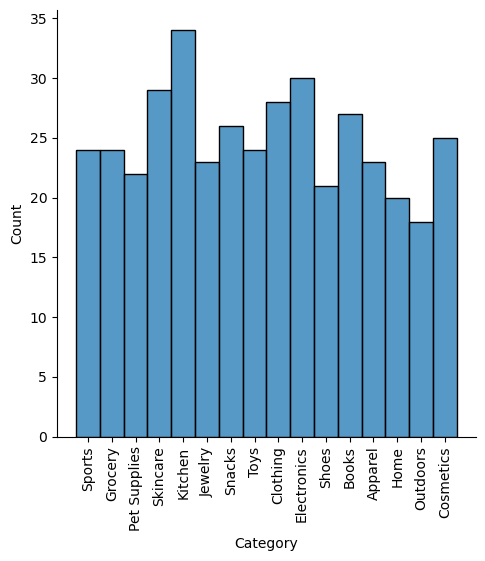

In [59]:
sns.displot(samples400["Category"])
plt.xticks(rotation=90)
plt.show()

We have a uniform distribution of categories.  

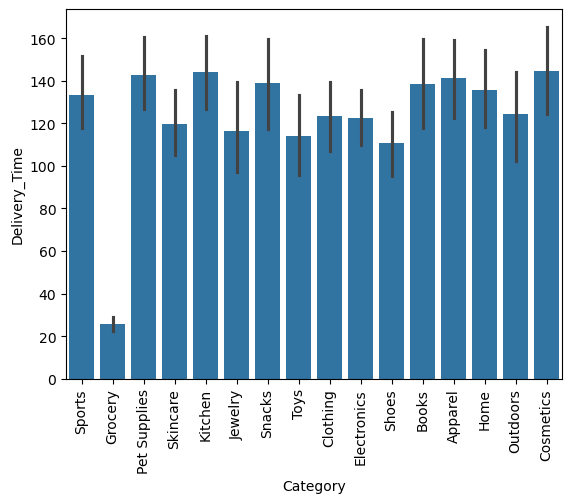

In [60]:
sns.barplot(x="Category", y="Delivery_Time", data=samples400)
plt.xticks(rotation=90)
plt.show()

Apart from grocery the Delivery_Time is not much different between categories.  
I will make a boolean but I will have to verify in the entire dataset if that's still the case (the grocery category being the only significantly different from the others).  

In [61]:
samples400["Grocery_noGrocery"] = np.where(samples400["Category"] == "Grocery", True, False)

In [62]:
samples400 = samples400.drop("Category", axis=1)

## **Vehicle**

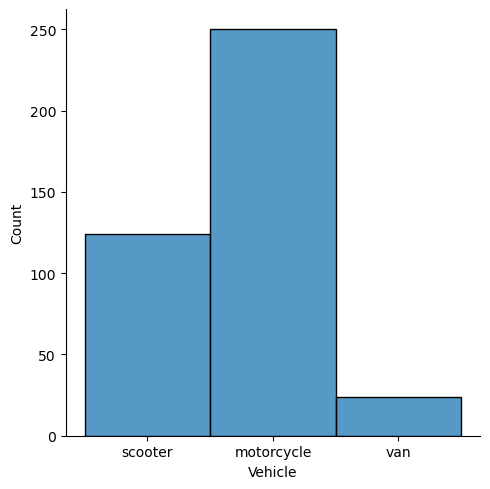

In [63]:
sns.displot(samples400["Vehicle"])

<Axes: xlabel='Vehicle', ylabel='Delivery_Time'>

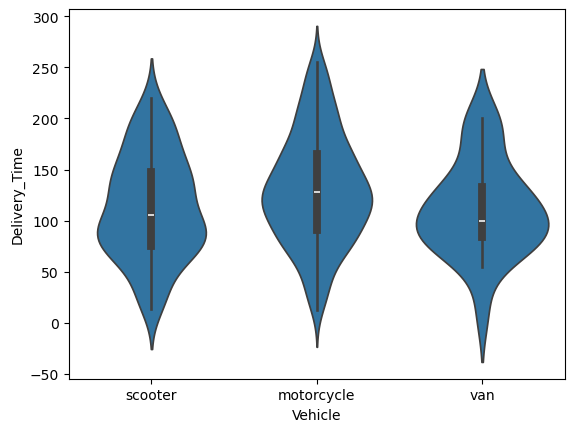

In [64]:
sns.violinplot(x="Vehicle", y="Delivery_Time", data=samples400)

I keep them. Same reason as before. Medians not so different but different distribution pattern

In [65]:
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Order_ID                398 non-null    object  
 1   Agent_Rating            398 non-null    float64 
 2   Weather                 398 non-null    category
 3   Traffic                 398 non-null    category
 4   Vehicle                 398 non-null    category
 5   Area                    398 non-null    category
 6   Delivery_Time           398 non-null    int64   
 7   Distance_Store_Drop_km  398 non-null    float64 
 8   Order_Day               398 non-null    int32   
 9   Young_vs_Older_Agents   398 non-null    category
 10  Period_Day              398 non-null    category
 11  Weather_Code            398 non-null    category
 12  Grocery_noGrocery       398 non-null    bool    
dtypes: bool(1), category(7), float64(2), int32(1), int64(1), object(1)
memory usage:

## **Traffic**

In [66]:
print(samples400.groupby("Traffic")["Delivery_Time"].describe())

         count        mean        std   min    25%    50%    75%    max
Traffic                                                                
Low      140.0  103.464286  42.172549  10.0   75.0  100.0  130.0  215.0
Medium    96.0  128.072917  49.690038  14.0   95.0  122.5  165.0  245.0
High      53.0  127.679245  55.876503  25.0   90.0  120.0  165.0  245.0
Jam      109.0  144.944954  57.472511  26.0  105.0  145.0  190.0  255.0


C:\Users\Angelique\AppData\Local\Temp\ipykernel_26400\2426879681.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(samples400.groupby("Traffic")["Delivery_Time"].describe())


Should I reorder the Traffic categories based on the Delivery_Time forthe predictive model?  


# **samples400 for predictive model**

In [67]:
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Order_ID                398 non-null    object  
 1   Agent_Rating            398 non-null    float64 
 2   Weather                 398 non-null    category
 3   Traffic                 398 non-null    category
 4   Vehicle                 398 non-null    category
 5   Area                    398 non-null    category
 6   Delivery_Time           398 non-null    int64   
 7   Distance_Store_Drop_km  398 non-null    float64 
 8   Order_Day               398 non-null    int32   
 9   Young_vs_Older_Agents   398 non-null    category
 10  Period_Day              398 non-null    category
 11  Weather_Code            398 non-null    category
 12  Grocery_noGrocery       398 non-null    bool    
dtypes: bool(1), category(7), float64(2), int32(1), int64(1), object(1)
memory usage:

In [68]:
samples400 = samples400.drop(["Order_ID","Weather"], axis=1)


In [69]:
with open("samples398_model.pkl","wb") as f:
    pickle.dump(samples400,f)